## Mostly Harmless Convolutions and Convolutional Neural Networks (CNNs)

Author: *Kaiyan Zhang, prAxIs UBC Team*

Date: 2025-06

### Part I: Introduction to Convolutions (in a Mostly Harmless Way)

<img src="data/convolution-operation-diagram.png" alt="A visualization of convolution operation" width="500"/>

#### Why Convolutions? 

Mathematically speaking, **Convolution** is an operation that combines two functions to produce a third function, which has a variety of applications in signal processing, image analysis and more. While this may sound complex, we can skip the mathematical parts of it and explain it in a less harmful and vivid way to our dear audiences (which is YOU). 

Let's begin by imagining a simple scenario: you took a picture of a cute dog, and you want to apply a filter to it so that it looks more vibrant and colorful. In the eyes of a computer, this picture is just a grid of numbers, where each number represents the color intensity of a pixel.


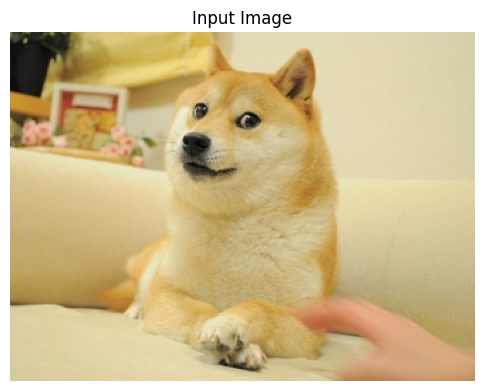

In [1]:
# Load necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Read the image in BGR format
doge_bgr = cv2.imread('data/Original_Doge_meme.jpg')

doge_rgb = cv2.cvtColor(doge_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6, 6))
plt.imshow(doge_rgb)
plt.axis('off')  
plt.title('Input Image')
plt.show()

Here, for demonstration purpose (also to protect our CPUs), I rescale the image to a 10 $\times$ 10 grid, where within each cell, the tuple represents the RGB values (0-255) of each pixel. Note that compressing images to a smaller size is always easier comparing to enhancing images to a larger size. While the resized image may not look as cute as the original one, it still contains the necessary information, and same ideas transits to larger images as well.

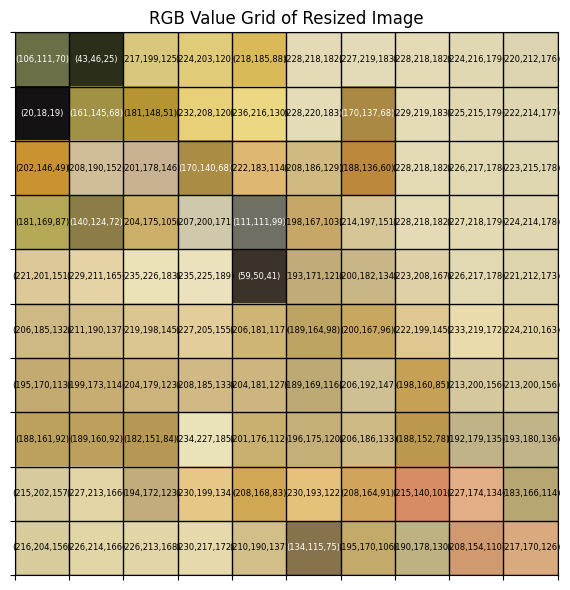

In [2]:
img_rgb = cv2.resize(doge_rgb, (10, 10), interpolation=cv2.INTER_NEAREST)

# Plot the RGB matrix
fig, ax = plt.subplots(figsize=(6, 6))


h, w = img_rgb.shape[:2]
ax.imshow(img_rgb, extent=[0, w, h, 0]) 

# Set ticks to show grid at pixel boundaries
ax.set_xticks(np.arange(0, w + 1, 1))
ax.set_yticks(np.arange(0, h + 1, 1))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(color='black', linewidth=1)

for i in range(h):
    for j in range(w):
        r, g, b = img_rgb[i, j]
        brightness = int(r) + int(g) + int(b)
        color = 'white' if brightness < 380 else 'black'
        ax.text(j + 0.5, i + 0.5, f'({r},{g},{b})',
                ha="center", va="center", fontsize=6, color=color)

ax.set_title("RGB Value Grid of Resized Image")
plt.tight_layout()
plt.show()

This has now become a little too abstract. Can you still identify the original image out of it? 

Alternatively, we can also plot out the distribution of the RGB values and frequencies in the image using a histogram. While this gives us a good idea of the color distribution, it does not tell us much about the spatial relationships between the pixels.

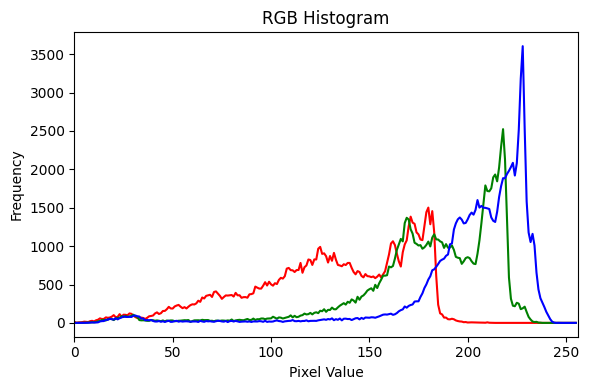

In [3]:
# Compute and plot the color histogram
colors = ('r', 'g', 'b')
plt.figure(figsize=(6, 4))

for i, col in enumerate(colors):
    hist = cv2.calcHist(
        images=[doge_bgr],       # source image (still in BGR)
        channels=[i],           # which channel: 0=B, 1=G, 2=R
        mask=None,              
        histSize=[256],         
        ranges=[0, 256]         
    )
    plt.plot(hist, color=col)
    plt.xlim([0, 256])

plt.title('RGB Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

The example above shows us what images are like in the eyes of a computer. Computers do not understand images in the same way that humans do, they can only see them as a collection of numbers. It makes sense that we need to apply some math to these numbers to either **change the image** or **extract some useful information** from it, and that's where convolution comes in.

#### How Does Convolution Work?

Before we dive into the application of it, let's first understand how convolution operate on an image in a more intuitive way:

Imagine you are copying a painting, you first made a draft of the same size against the original painting and now you want to color it. Other than making your painting a 100% identical copy, you want to add some personal touch to it, so you decide to use a brush with a specific pattern to color the draft. Wherever you apply the brush, it will color the region it touches with a brighter color than the original painting, and your color your draft from left to right, top to bottom, until the whole draft is colored with the brush. You end up with a new painting that is similar to the original one, but with a different style.

Here, the brush you used is called a **kernel** in the context of convolution, and the process of applying the brush is what we call **convolution operation**. We would define the kernel as a small matrix of numbers that represents the pattern of the brush, and the convolution operation as the process of transforming the original image by applying the kernel to it.

Here is a gif that illustrates how our filter (the kernel) will work on the image. You can see it as the small brush that slides over the image, operating on a small region of the image at a time, and eventually producing a new image that was completely transformed by the filter.

![Convolution Example](data/sharpener_kernel.gif)

Now, let's return to the example of the cute dog picture. What we are going to apply is a kernel called **sharpening filter**, it is a 3 $\times$ 3 matrix that looks like this:

$$\begin{bmatrix}
 0 &-1 & 0 \\
-1 & 5 & -1 \\
 0 & -1 & 0 
\end{bmatrix}$$
**Don't panic** as we are not going to do any math here, we will just let the computer do the math for us. The only thing you need to know is that this kernel will enhance the edges of the image, making it look sharper and more defined.

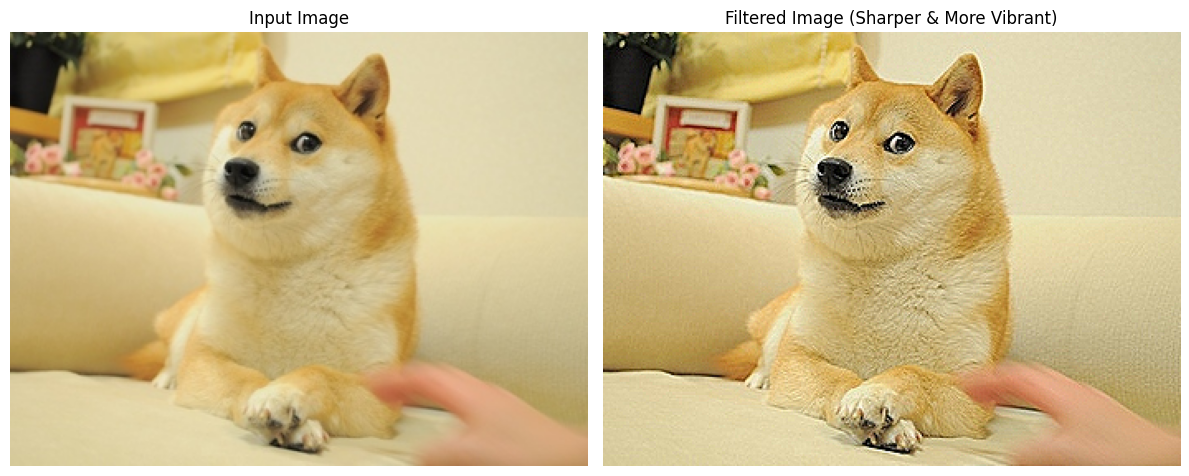

In [4]:
# Define the sharpening filter
kernel = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
], dtype=np.float32)

# Apply the kernel to the color image using filter2D.
filtered = cv2.filter2D(doge_rgb, ddepth=-1, kernel=kernel)

filtered = np.clip(filtered, 0, 255).astype(np.uint8)

# Display the original and filtered images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Input
ax1.imshow(doge_rgb)
ax1.set_title("Input Image")
ax1.axis("off")

# Output
ax2.imshow(filtered)
ax2.set_title("Filtered Image (Sharper & More Vibrant)")
ax2.axis("off")

plt.tight_layout()
plt.show()

I guess the difference is quite obvious now, right? The sharpened image has more contrast and the edges are more defined, making it look more vibrant and colorful. This is the power of convolution, it allows us to apply filters to images and transform them in a way that is not possible with simple pixel manipulation.

However, convolution on image is not limited to filtering, it can also be used to extract features from the image. For example, we can use a kernel to detect edges, lines and texts in images, we can even use specific kernels to detect specific shapes or patterns in images (for example, a kernel that detects anything that looks like a dog). 

Here is an example of a kernel that detects edges in an image:
$$\text{Vertical Kernel} = \begin{bmatrix}
 1 & 0 & -1 \\
 1 & 0 & -1 \\
 1 & 0 & -1
\end{bmatrix} 
\text{, }
\text{Horizontal Kernel} = \begin{bmatrix}
 1 & 1 & 1 \\
 0 & 0 & 0 \\
 -1 & -1 & -1
\end{bmatrix} 
$$

Still, **don't panic** as we are not going to do any math here. All you need to know is this kernel is called **Sobel filter**, and what it does is to highlight the edges in the image, making them more visible. 

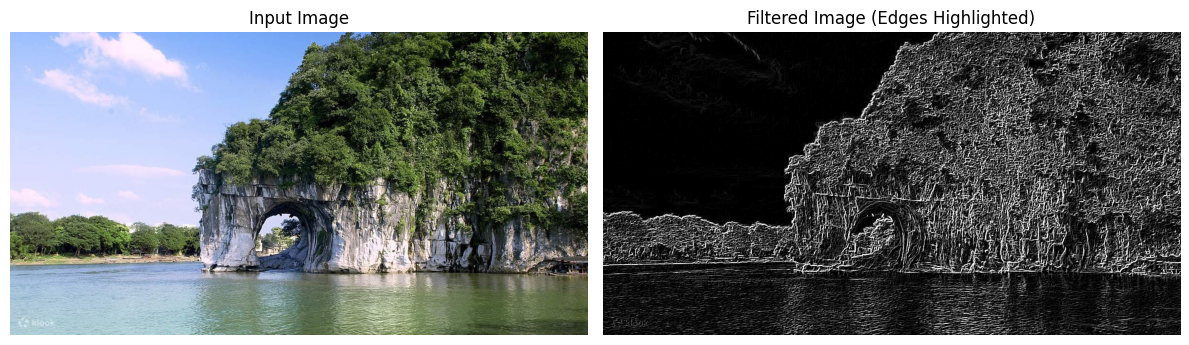

In [7]:
# Generate a greyscale version of the image
hill_bgr = cv2.imread('data/xiangbishan.jpg')

hill_rgb = cv2.cvtColor(hill_bgr, cv2.COLOR_BGR2RGB)

hill_gray = cv2.cvtColor(hill_bgr, cv2.COLOR_BGR2GRAY)

# Define the Sobel filter kernel
sb_kernel_v = np.array([
    [ 1, 0, -1],
    [ 1, 0, -1],
    [ 1, 0, -1]
], dtype=np.float32)

sb_kernel_h = np.array([
    [ 1, 1, 1],
    [ 0, 0, 0],
    [-1, -1, -1]], dtype=np.float32)

# Apply the kernel to the color image using filter2D.
vert = cv2.filter2D(hill_gray, -1, sb_kernel_v)

horiz = cv2.filter2D(hill_gray, -1, sb_kernel_h)

combined = cv2.convertScaleAbs(np.sqrt(vert.astype(np.float32)**2 + horiz.astype(np.float32)**2))

# Display the original and filtered images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Input
ax1.imshow(hill_rgb)
ax1.set_title("Input Image")
ax1.axis("off")

# Output
ax2.imshow(combined, cmap = 'gray')
ax2.set_title("Filtered Image (Edges Highlighted)")
ax2.axis("off")

plt.tight_layout()
plt.show()

As we can see in the example above, the Sobel filter detects the edges in the image and highlights them like a fineliner pen. This is a very useful technique in image processing, as it allows us to extract features from the image that can be used for further analysis or classification.

### II. Introduction to Convolutional Neural Networks (CNNs) (Hopefully Not Too Harmful)


### References